# Assignment 1: 
Cornelis de Jager n8891974<br>
Daniel Brandenburg n8867887<br>
Joel Schwaber n10241337<br>

In [47]:
# Run this if pydot needs to be installed
!pip install pydot
!pip install eli5
!pip install imblearn

In [48]:
# Imports
import pandas as pd
import numpy as np
import scipy.stats as stats
import eli5

# Import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline

# Import ML libraries
from sklearn.preprocessing import Imputer
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import export_graphviz
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.ensemble import VotingClassifier
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# Set a random state value
rs = 10

#import libraries to visualize decision trees
import pydot
from io import StringIO


# Ignore Warnings and ignore them
import warnings
warnings.filterwarnings("ignore")

In [77]:
def categoricalPlot(cat, cat2 = 'IsBadBuy'): # Cat is the carigorical as a string i.e 'Size'
    pd.crosstab(data[cat],data[cat2]).plot(kind="bar")
    
def CreateAveragedColumn (A, B):
    C = [np.nan] * len( A )
    for i in range(len(A)):
        C[i] = (A[i] + B[i])/2
    
    return C

def IdentifyOutliers (column):
    data_described = column.describe()
    Q1 = data_described["25%"]
    Q3 = data_described["75%"]
    IQR = Q3-Q1
    lowerLimit = Q1 - 1.5 * IQR
    upperLimit = Q3 + 1.5 * IQR
    output = [np.nan] * len( column )
    for i in range(len(column)):
        value = column[i]
        if value < lowerLimit or value > upperLimit:
            output[i] = True
        else:
            output[i] = False
    return output

def analyse_feature_importance(dm_model, feature_names, n_to_display=5):
    # grab feature importances from the model
    importances = dm_model.feature_importances_
    
    # sort them out in descending order
    indices = np.argsort(importances)
    indices = np.flip(indices, axis=0)

    # limit to 20 features, you can leave this out to print out everything
    indices = indices[:n_to_display]

    for i in indices:
        print(feature_names[i], ':', importances[i])
        
# Define a function to find the root node
def getTreeInfo(model, feature_names):
    n_nodes = model.tree_.node_count
    children_left = model.tree_.children_left
    children_right = model.tree_.children_right
    feature = model.tree_.feature
    threshold = model.tree_.threshold
    features  = [feature_names[i] for i in model.tree_.feature]    

    # The tree structure can be traversed to compute various properties such
    # as the depth of each node and whether or not it is a leaf.
    leaf_count = 0
    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1
        
        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            leaf_count += 1
            is_leaves[node_id] = True


    main_variables = "Root feature is " 
    main_variables += features[0]
    main_variables += "\n"
    main_variables += "Competing featues are "
    main_variables += features[1]
    main_variables += 'and '
    main_variables += features[2]
    return [n_nodes, leaf_count, main_variables]
    
# Write a function that imputes median
def ImputeMean(series):
    return series.fillna(series.mean())

def Normalize (column):
    column =  (column - column.min())/(column.max() - column.min())
    return column

def LogTransform (column):
    column = math.log(column)

In [50]:
def PreProcessing (data):
    print("Pre-Processing Step")
    
    # Check if there are any missing target variables
    if data['IsBadBuy'].isna().any():
        print("Missing Target Variables")
    else:
        print("No missing Target Variables")
    
    
    # Handle Bad Columns drop Columns
    data.drop(['PRIMEUNIT', 'AUCGUART', 'WheelTypeID', 'ForSale', 'PurchaseDate', 'IsOnlineSale'], 
              axis=1, 
              inplace=True)
    

    # Handle Missing Values
    i = 0            # Python's indexing starts at zero
    for item in data['TopThreeAmericanName']:   # Python's for loops are a "for each" loop 
        if data['TopThreeAmericanName'][i] == np.nan and  data['Make'][i] == 'Hyundai':
            data['TopThreeAmericanName'][i] = 'HYUNDAI'
        i += 1
        
    i = 0            # Python's indexing starts at zero
    for item in data['TopThreeAmericanName']:   # Python's for loops are a "for each" loop 
        if data['TopThreeAmericanName'][i] == np.nan and  data['Make'][i] == 'Jeep':
            data['TopThreeAmericanName'][i] = 'JEEP'
        i += 1
        
        
    # Standardise the capitilization across all object rows
    obj_cols = data.select_dtypes(include='object').columns # Create a list of col names
    for i in obj_cols:              # Interate over the obj_cols list
        data[i] = data[i].str.upper()   # Convert all strings to uppercase  
    # Standardize USA to AMERICA
    data['Nationality'].replace({'USA' : 'AMERICAN'}, inplace = True)
    
    # Turn Transmission into a binary variable with Auto = 1 and Manual = 0
    data.rename({'Transmission' : 'Auto'}, axis = 1, inplace = True)
    # Replace binary columns with 1s and 0s
    data['Auto'].replace({'MANUAL' : 0, 'AUTO' : 1}, inplace=True)
    
    # Remove NOT AVAIL in color and place it in the NaN section
    data['Color'].replace({'NOT AVAIL': np.nan}, inplace = True)
    
    
     #This is the significance test for 
    # Check to see if VNST is a statisically significant variable
    # Create a distribution of IsBuyBad for VNST
    VNST_badBuy = pd.crosstab(data['IsBadBuy'], data['VNST']).loc[0]
    VNST_goodBuy = pd.crosstab(data['IsBadBuy'], data['VNST']).loc[1]
    pd.crosstab(data['VNST'],data['IsBadBuy']).plot(kind="bar")
    
    # Use a Chi2 test to test if there is any corrilation between them, if there is
    # (p < 0.05) discarde the variable
    fScore, pValue = stats.f_oneway(VNST_badBuy, VNST_goodBuy)
    print("The pValaue is " + str(pValue) + " which is significant enough to reject null hypothesis")
    print("Drop VNST due to statistical insignificance")
    data.drop('VNST', axis=1, inplace = True)
    
    # Seperate the Size feature into Size and Body
    tempSize = data['Size'].str.split(' ', expand = True) # Create temp var with split column
    data['Size'] = tempSize[0] # Save the temp var back into data
    data['Body'] = tempSize[1] # Save the temp var back into data
    data['Body'].fillna('CITY', inplace = True) # Assume any other cars are 'City'
    
    
    data.loc[data.Size == 'VAN', 'Body'] = 'Van' # Convert Van into a body type
    data.loc[data.Size == 'VAN', 'Body'] =  np.nan # Take van away from size, shouldn't matter once OH is done
    
    # Converting the TimeStamp into Quater
    Quarter = [] # Create empty string
    for i, _ in enumerate(data.PurchaseTimestamp): # Loop over the entire dataset
        # Convert the epoch datetime into the quater and append to list
        Quarter.append(pd.Timestamp(data.PurchaseTimestamp.loc[i], unit = 's').quarter)        
    data['Quarter'] = Quarter # Create the column with list
    data.drop('PurchaseTimestamp', axis=1, inplace = True) # Drop old TimeStamp
    
    """ This will take care of any Null values we don't specifically take care of
    by replaceing the missing data with data from the same distibution"""
   
    data['MMRAcquisitionAuctionAveragePrice'] = data['MMRAcquisitionAuctionAveragePrice'].replace(0, np.nan)
    data['MMRAcquisitionAuctionCleanPrice'] = data['MMRAcquisitionAuctionCleanPrice'].replace(0, np.nan)
    data['MMRAcquisitionRetailAveragePrice'] = data['MMRAcquisitionRetailAveragePrice'].replace(0, np.nan)
    data['MMRAcquisitonRetailCleanPrice'] = data['MMRAcquisitonRetailCleanPrice'].replace(0, np.nan)
    data['MMRCurrentAuctionAveragePrice'] = data['MMRCurrentAuctionAveragePrice'].replace(0, np.nan)
    data['MMRCurrentAuctionCleanPrice'] = data['MMRCurrentAuctionCleanPrice'].replace(0, np.nan)
    data['MMRCurrentRetailAveragePrice'] = data['MMRCurrentRetailAveragePrice'].replace(0, np.nan)
    data['MMRCurrentRetailCleanPrice'] = data['MMRCurrentRetailCleanPrice'].replace(0, np.nan)    
    
    # Impute and normalize
    data["MMRAcquisitionAuctionAveragePrice"] = ImputeMean(data["MMRAcquisitionAuctionAveragePrice"])
    data["MMRAcquisitionAuctionCleanPrice"] =  ImputeMean(data["MMRAcquisitionAuctionCleanPrice"])
    data["MMRAcquisitionRetailAveragePrice"] =  ImputeMean(data["MMRAcquisitionRetailAveragePrice"])
    data["MMRAcquisitonRetailCleanPrice"] =  ImputeMean(data["MMRAcquisitonRetailCleanPrice"])
    data["MMRCurrentAuctionAveragePrice"] =  ImputeMean(data["MMRCurrentAuctionAveragePrice"])
    data["MMRCurrentAuctionCleanPrice"] =  ImputeMean(data["MMRCurrentAuctionCleanPrice"])
    data["MMRCurrentRetailAveragePrice"] =  ImputeMean(data["MMRCurrentRetailAveragePrice"])
    data["MMRCurrentRetailCleanPrice"] =  ImputeMean(data["MMRCurrentRetailCleanPrice"])
    
    data["VehOdo"] = ImputeMean(data["VehOdo"])
    data["VehBCost"] = ImputeMean(data["VehBCost"])
    data["WarrantyCost"] = ImputeMean(data["WarrantyCost"])
    
    print(np.corrcoef(data["MMRAcquisitionAuctionAveragePrice"], data["MMRAcquisitionAuctionCleanPrice"]))
    print(np.corrcoef(data["MMRAcquisitionRetailAveragePrice"], data["MMRAcquisitonRetailCleanPrice"]))
    print(np.corrcoef(data["MMRCurrentAuctionAveragePrice"], data["MMRCurrentAuctionCleanPrice"]))
    print(np.corrcoef(data["MMRCurrentRetailAveragePrice"], data["MMRCurrentRetailCleanPrice"])) 
    
    print(data["MMRAcquisitionAuctionAveragePrice"][data["MMRAcquisitionAuctionAveragePrice"] == 0])
    
    """ Create the new columns """
    data["AcquisitionAuctionprice"] = CreateAveragedColumn(data["MMRAcquisitionAuctionAveragePrice"], data["MMRAcquisitionAuctionCleanPrice"])
    data["AcquisitionRetailPrice"] = CreateAveragedColumn(data["MMRAcquisitionRetailAveragePrice"], data["MMRAcquisitonRetailCleanPrice"])
    data["MMRCurrentAuctionPrice"] = CreateAveragedColumn(data["MMRCurrentAuctionAveragePrice"], data["MMRCurrentAuctionCleanPrice"])
    data["MMRCurrentRetailPrice"] = CreateAveragedColumn(data["MMRCurrentRetailAveragePrice"], data["MMRCurrentRetailCleanPrice"])
    
    
    data.drop('MMRAcquisitionAuctionAveragePrice', inplace = True, axis = 1)
    data.drop('MMRAcquisitionAuctionCleanPrice', inplace = True, axis = 1)
    data.drop('MMRAcquisitonRetailCleanPrice', inplace = True, axis = 1)
    data.drop('MMRCurrentAuctionAveragePrice', inplace = True, axis = 1)
    data.drop('MMRCurrentAuctionCleanPrice', inplace = True, axis = 1)
    data.drop('MMRCurrentRetailAveragePrice', inplace = True, axis = 1)
    data.drop('MMRCurrentRetailCleanPrice', inplace = True, axis = 1)
    data.drop('MMRAcquisitionRetailAveragePrice', inplace = True, axis = 1)
    
    conv = []
    for i in data.columns: # Loop over dataset
        if data[i].isna().any() == True: # Check to see if there is a NaN is the feature
            dist = data[i].value_counts(normalize=True) # Find the distrabution of the column
            missing = data[i].isna() # Find where the NaN are
            # Replace the NaNs with values from the same distrabution of the column
            data.loc[missing, i] = np.random.choice(dist.index, size=len(data[missing]),p=dist.values)       
            conv.append(i)
            
    print("Converted all of " , conv, "s missing values into the same distrubution")
    
    
    # Do the box plot
    
    fig = plt.figure()
    data.boxplot(column=['AcquisitionAuctionprice', 'AcquisitionRetailPrice', 'MMRCurrentAuctionPrice', 'MMRCurrentRetailPrice'], grid = False, rot = 30)
    plt.savefig('preOutlierBox_Pricing', bbox_inches = "tight")
    plt.show
    
    fig = plt.figure()
    data.boxplot(column=['VehOdo', 'VehBCost', 'WarrantyCost'], grid = False, rot = 30)
    plt.savefig('preOutlierBox_VehicleDetails', bbox_inches = "tight")
    plt.show
    
     # Now do histograms
    fig = plt.figure()
    ax1 = fig.add_subplot(2,2,1)
    plt.subplots_adjust(hspace=0.4, wspace = 0.3)
    ax1 =  data["AcquisitionAuctionprice"].hist()
    ax1.set_title("AcquisitionAuctionprice")
    ax1.grid(False)
    
    ax2 = fig.add_subplot(2,2,2)
    ax2 =  data["AcquisitionRetailPrice"].hist()
    ax2.set_title("AcquisitionRetailPrice")
    ax2.grid(False)
    
    ax3 = fig.add_subplot(2,2,3)
    ax3 =  data["MMRCurrentAuctionPrice"].hist()
    ax3.set_title("MMRCurrentAuctionPrice")
    ax3.grid(False)
    
    ax4 = fig.add_subplot(2,2,4)
    ax4 =  data["MMRCurrentRetailPrice"].hist()
    ax4.set_title("MMRCurrentRetailPrice")
    ax4.grid(False)    
    
    plt.savefig('preOutlierHist1', bbox_inches = "tight")
    plt.show()

     # Now do histograms
    fig = plt.figure()
    ax1 = fig.add_subplot(1,3,1)
    plt.subplots_adjust(hspace=0.4, wspace = 0.3)
    ax1 =  data["VehOdo"].hist()
    ax1.set_title("VehOdo")
    ax1.grid(False)
    
    ax2 = fig.add_subplot(1,3,2)
    ax2 =  data["VehBCost"].hist()
    ax2.set_title("VehBCost")
    ax2.grid(False)
    
    ax3 = fig.add_subplot(1,3,3)
    ax3 =  data["WarrantyCost"].hist()
    ax3.set_title("WarrantyCost")
    ax3.grid(False)
    
    
    plt.savefig('preOutlierHist2', bbox_inches = "tight")
    plt.show()
    ## Identify and Remove outiers
    outliers = (IdentifyOutliers(data["AcquisitionAuctionprice"]) and
                IdentifyOutliers(data["AcquisitionRetailPrice"]) and
                IdentifyOutliers(data["MMRCurrentAuctionPrice"]) and
                IdentifyOutliers(data["MMRCurrentRetailPrice"]) and
                IdentifyOutliers(data["VehOdo"]))
    
    # Select lines that aren't outliers
    num_lines =  len(data["MMRCurrentRetailPrice"])
    data = data[[not i for i in outliers]]
    print ("Lines Removed: ", num_lines - len(data["MMRCurrentRetailPrice"]))
    
    # Do the box plot
    fig = plt.figure()
    data.boxplot(column=['AcquisitionAuctionprice', 'AcquisitionRetailPrice', 'MMRCurrentAuctionPrice', 'MMRCurrentRetailPrice'], grid = False, rot = 30)
    plt.savefig('PostOutlierBox_Pricing', bbox_inches = "tight")
    plt.show
    
    fig = plt.figure()
    data.boxplot(column=['VehOdo', 'VehBCost', 'WarrantyCost'], grid = False, rot = 30)
    plt.savefig('PostOutlierBox_VehicleDetails', bbox_inches = "tight")
    plt.show
    
    
    # Now do histograms
    fig = plt.figure()
    plt.subplots_adjust(hspace=0.4, wspace = 0.3)
    ax1 = fig.add_subplot(2,2,1)
    ax1 =  data["AcquisitionAuctionprice"].hist()
    ax1.set_title("AcquisitionAuctionprice")
    ax1.grid(False)
    ax2 = fig.add_subplot(2,2,2)
    ax2 =  data["AcquisitionRetailPrice"].hist()
    ax2.set_title("AcquisitionRetailPrice")
    ax2.grid(False)
    ax3 = fig.add_subplot(2,2,3)
    ax3 =  data["MMRCurrentAuctionPrice"].hist()
    ax3.set_title("MMRCurrentAuctionPrice")
    ax3.grid(False)
    ax4 = fig.add_subplot(2,2,4)
    ax4 =  data["MMRCurrentRetailPrice"].hist()
    ax4.set_title("MMRCurrentRetailPrice")
    ax4.grid(False)
    plt.savefig('postOutlierHist', bbox_inches = "tight")
    plt.show()
    
    fig = plt.figure()
    ax1 = fig.add_subplot(1,3,1)
    plt.subplots_adjust(hspace=0.4, wspace = 0.3)
    ax1 =  data["VehOdo"].hist()
    ax1.set_title("VehOdo")
    ax1.grid(False)
    
    ax2 = fig.add_subplot(1,3,2)
    ax2 =  data["VehBCost"].hist()
    ax2.set_title("VehBCost")
    ax2.grid(False)
    
    ax3 = fig.add_subplot(1,3,3)
    ax3 =  data["WarrantyCost"].hist()
    ax3.set_title("WarrantyCost")
    ax3.grid(False)
    
    
    plt.savefig('preOutlierHist2', bbox_inches = "tight")
    plt.show()
    # Transform the skew values
    data["AcquisitionAuctionprice"] = np.sqrt(data["AcquisitionAuctionprice"])
    data["MMRCurrentAuctionPrice"] = np.sqrt(data["MMRCurrentAuctionPrice"])
    data["WarrantyCost"] = np.log(data["WarrantyCost"])
    
    data["AcquisitionAuctionprice"] = Normalize(data["AcquisitionAuctionprice"])
    data["AcquisitionRetailPrice"] = Normalize(data["AcquisitionRetailPrice"])
    data["MMRCurrentAuctionPrice"] = Normalize(data["MMRCurrentAuctionPrice"])
    data["MMRCurrentRetailPrice"] = Normalize(data["MMRCurrentRetailPrice"])
    data["VehOdo"] = Normalize(data["VehOdo"])
    data["VehBCost"] = Normalize(data["VehBCost"])
    data["WarrantyCost"] = Normalize(data["WarrantyCost"])
    
    # Do the box plot
    fig = plt.figure()
    data.boxplot(column=['AcquisitionAuctionprice', 'AcquisitionRetailPrice', 'MMRCurrentAuctionPrice', 'MMRCurrentRetailPrice'], grid = False, rot = 30)
    plt.savefig('PostTransformationBox_Pricing', bbox_inches = "tight")
    plt.show
    
    fig = plt.figure()
    data.boxplot(column=['VehOdo', 'VehBCost', 'WarrantyCost'], grid = False, rot = 30)
    plt.savefig('PostTransformationOutlierBox_VehicleDetails', bbox_inches = "tight")
    plt.show
    
    # Now do histograms
    fig = plt.figure()
    ax1 = fig.add_subplot(2,2,1)
    ax1 =  data["AcquisitionAuctionprice"].hist()
    ax1.grid(False)
    ax2 = fig.add_subplot(2,2,2)
    ax2 =  data["AcquisitionRetailPrice"].hist()
    ax2.grid(False)
    ax3 = fig.add_subplot(2,2,3)
    ax3 =  data["MMRCurrentAuctionPrice"].hist()
    ax3.grid(False)
    ax4 = fig.add_subplot(2,2,4)
    ax4 =  data["MMRCurrentRetailPrice"].hist()
    ax4.grid(False)
    plt.show()
    
    fig = plt.figure()
    ax1 = fig.add_subplot(1,3,1)
    plt.subplots_adjust(hspace=0.4, wspace = 0.3)
    ax1 =  data["VehOdo"].hist()
    ax1.set_title("VehOdo")
    ax1.grid(False)
    
    ax2 = fig.add_subplot(1,3,2)
    ax2 =  data["VehBCost"].hist()
    ax2.set_title("VehBCost")
    ax2.grid(False)
    
    ax3 = fig.add_subplot(1,3,3)
    ax3 =  data["WarrantyCost"].hist()
    ax3.set_title("WarrantyCost")
    ax3.grid(False)
    
    
    plt.savefig('preOutlierHist2', bbox_inches = "tight")
    plt.show()
    
    """ plot the categorial data """
    fig = plt.figure()
    ax1 =  data["Make"].value_counts().plot(kind = 'bar')
    ax1.set_title("Make")
    ax1.grid(False)
    plt.savefig('makeHist', bbox_inches = "tight")
    plt.show()
    
    fig = plt.figure()
    ax1 =  data["Color"].value_counts().plot(kind = 'bar')
    ax1.set_title("Color")
    ax1.grid(False)
    plt.savefig('colourHist', bbox_inches = "tight")
    plt.show()
    
    fig = plt.figure()
    plt.subplots_adjust(hspace=0.8, wspace = 0.4)
    ax1 = fig.add_subplot(2,2,1)
    ax1 =  data["VehYear"].value_counts().plot(kind = 'bar', rot = 90)
    ax1.set_title("VehYear")
    ax1.grid(False)
    ax2 = fig.add_subplot(2,2,2)
    ax2 =  data["Auction"].value_counts().plot(kind = 'bar', rot = 90)
    ax2.set_title("Auction")
    ax2.grid(False)
    ax3 = fig.add_subplot(2,2,3)
    ax3 =  data["Size"].value_counts().plot(kind = 'bar', rot = 90)
    ax3.set_title("Size")
    ax3.grid(False)
    ax4 = fig.add_subplot(2,2,4)
    ax4 =  data["Body"].value_counts().plot(kind = 'bar', rot = 90)
    ax4.set_title("Body")
    ax4.grid(False)
    plt.savefig('othersHist', bbox_inches = "tight")
    plt.show()
    
   
    """ This should be the last thing done """
    # Convert all categorical variables into one hot representations
    
    print("The number of features before one hot encoding is " + str(data.shape[1]))
    data_OH = pd.get_dummies(data, columns = ['Auction', 'Make', 'Color', 'VehYear', 
                                              'Nationality', 'Size', 'Body', 'TopThreeAmericanName', 
                                              'WheelType', 'Quarter'])
    print("The number of features after one hot encoding is " + str(data_OH.shape[1]))
    data_OH ["IsBadBuy"] = data['IsBadBuy']
    
    data.describe()
    data.info()
    
    return data, data_OH

Pre-Processing Step
No missing Target Variables
The pValaue is 0.0025217411235946108 which is significant enough to reject null hypothesis
Drop VNST due to statistical insignificance
[[1.         0.98128594]
 [0.98128594 1.        ]]
[[1.         0.98799717]
 [0.98799717 1.        ]]
[[1.        0.9822403]
 [0.9822403 1.       ]]
[[1.         0.98928933]
 [0.98928933 1.        ]]
Series([], Name: MMRAcquisitionAuctionAveragePrice, dtype: float64)
Converted all of  ['Auction', 'VehYear', 'Make', 'Color', 'Auto', 'WheelType', 'Nationality', 'Size', 'TopThreeAmericanName', 'MMRCurrentRetailRatio', 'Body'] s missing values into the same distrubution


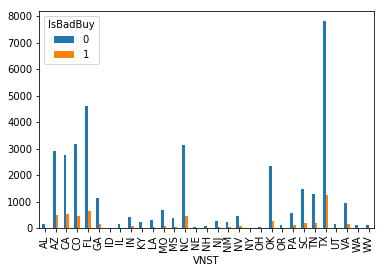

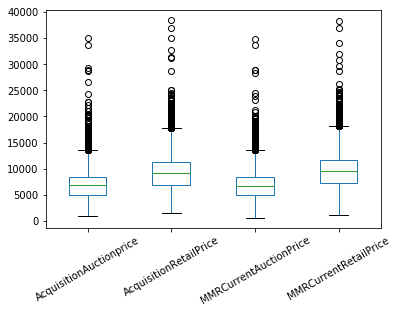

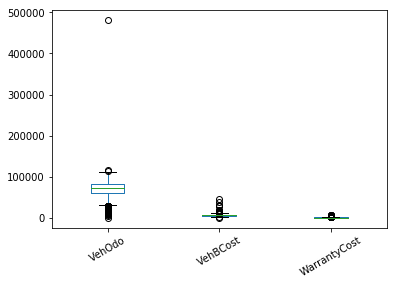

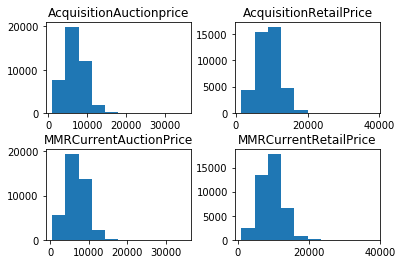

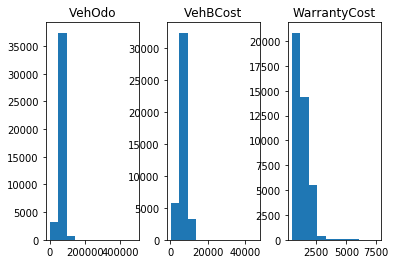

Lines Removed:  187


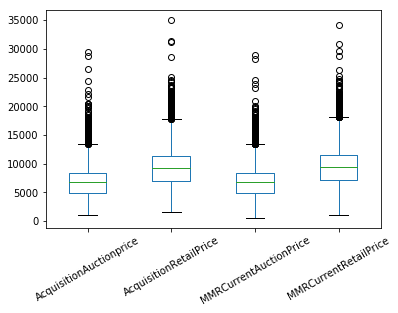

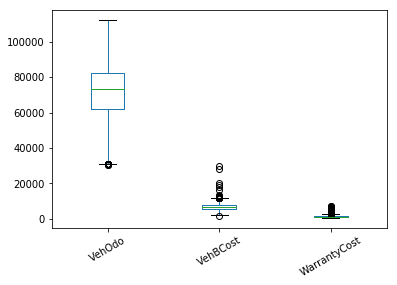

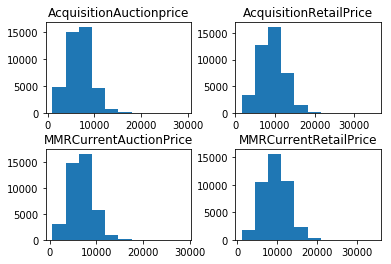

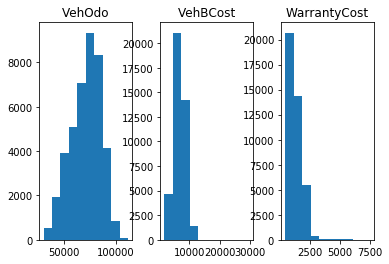

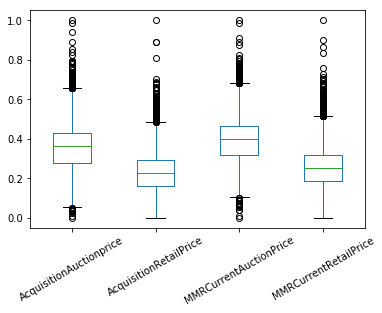

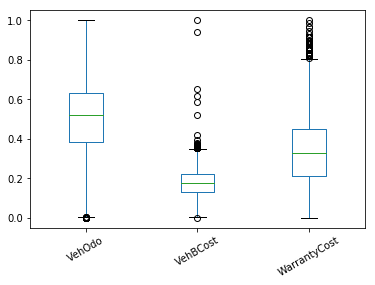

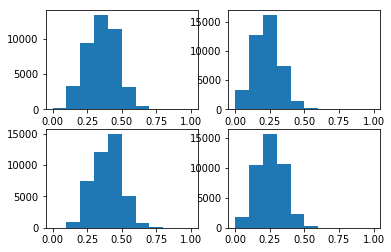

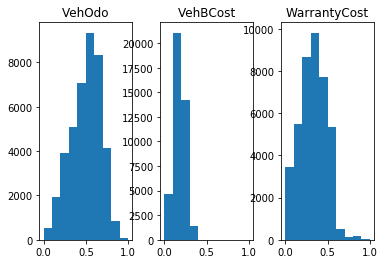

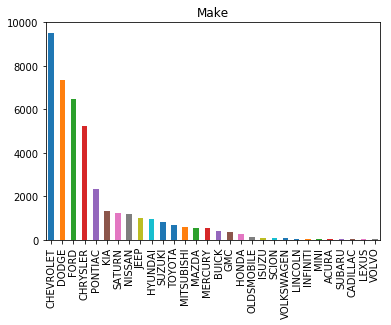

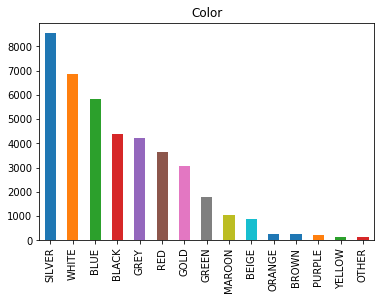

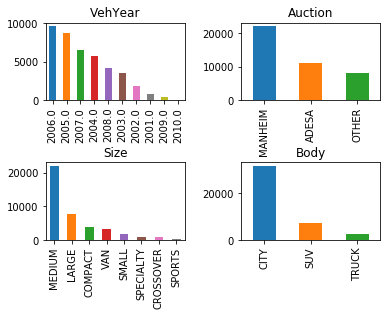

The number of features before one hot encoding is 20
The number of features after one hot encoding is 94
<class 'pandas.core.frame.DataFrame'>
Int64Index: 41289 entries, 0 to 41475
Data columns (total 20 columns):
Auction                    41289 non-null object
VehYear                    41289 non-null float64
Make                       41289 non-null object
Color                      41289 non-null object
Auto                       41289 non-null float64
WheelType                  41289 non-null object
VehOdo                     41289 non-null float64
Nationality                41289 non-null object
Size                       41289 non-null object
TopThreeAmericanName       41289 non-null object
MMRCurrentRetailRatio      41289 non-null float64
VehBCost                   41289 non-null float64
WarrantyCost               41289 non-null float64
IsBadBuy                   41289 non-null int64
Body                       41289 non-null object
Quarter                    41289 non-null int6

In [51]:
data_raw = pd.read_csv("Kick.csv", # Read the csv into a DF
                   index_col = 'PurchaseID', 
                   na_values = ('?',  '#VALUE!'))

data, data_OH = PreProcessing(data_raw) # PreProcess the data

counts = data["IsBadBuy"].value_counts()
total = data["IsBadBuy"].count()
    
# calculate the percentage
# kick is where IsBadBuy == 1
kickPersentage = counts[1] / total * 100
print ("Questin 1.1 :")
print( kickPersentage, "%")

# target/input split
y = data_OH['IsBadBuy']
X = data_OH.drop(['IsBadBuy'], axis=1)

X_mat = X.values # Canvert X into a matrix
X_train, X_test, y_train, y_test = train_test_split(X_mat, y, test_size=0.2, stratify=y, random_state=rs)

# Do the resampling
ros = RandomOverSampler(random_state=0)
X_train, y_train = ros.fit_resample(X_train, y_train)


<h1>Task 2</h1>

In [52]:
# simple decision tree training
DecisionTreeModel = DecisionTreeClassifier(random_state=rs)
DecisionTreeModel.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best')

<h2>Task 2.1</h2>
<h3>A: What is the test accuracy?</h3>    

In [53]:
print("Test Model Accuracy:", DecisionTreeModel.score(X_test, y_test))
print("Train Model Accuracy:", DecisionTreeModel.score(X_train, y_train))

Test Model Accuracy: 0.7961976265439574
Train Model Accuracy: 1.0


<h3>B: What is the size of the tree?</h3>  

In [54]:
print("Number of Nodes:", DecisionTreeModel.tree_.node_count)

Number of Nodes: 9325


<h3>C: How many leaves are in the tree that is selected based on the validation data set?</h3>  

In [55]:
print("Answer To be fileld IN")

Answer To be fileld IN


<h3>D: Which variable is used for the first split? What are the competing splits for this first split? </h3> 

In [56]:
feature_names = X.columns
getTreeInfo(DecisionTreeModel, feature_names) # Call the root function

The binary tree structure has  9325  nodes and has  4663  leaves
Root feature is  MMRCurrentAuctionPrice
Competing featues are  VehBCost and  VehOdo


<h3>E: What are the 5 important variables in building the tree?</h3> 

In [57]:
analyse_feature_importance(DecisionTreeModel, feature_names, n_to_display=5)

MMRCurrentAuctionPrice : 0.12114385232750587
VehOdo : 0.10540932338104037
VehBCost : 0.09927066615740204
MMRCurrentRetailRatio : 0.09640821548985276
AcquisitionRetailPrice : 0.08330435804286253


<h3>F: Report if you see any evidence of model overfitting</h3> 

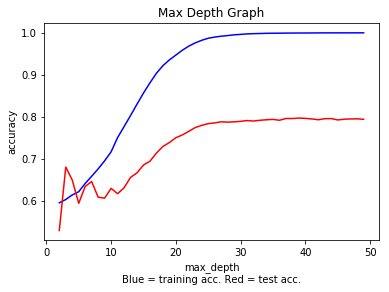

In [58]:
test_score = []
train_score = []

currRange = range(2 , DecisionTreeModel.tree_.max_depth)
# check the model performance for max depth from 2-20
for max_depth in currRange:
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=rs)
    model.fit(X_train, y_train)
    
    test_score.append(model.score(X_test, y_test))
    train_score.append(model.score(X_train, y_train))
    
# plot max depth hyperparameter values vs training and test accuracy score
plt.plot(currRange, train_score, 'b', currRange, test_score, 'r')
plt.xlabel('max_depth\nBlue = training acc. Red = test acc.')
plt.ylabel('accuracy')
plt.title('Max Depth Graph')
plt.show()

<p>As seen from the graph above, the error is low and accuracy is very high at the same depth as the original model, this is a clear sign of overfitting.</p>

<h3>G: Did changing the default setting help improving the model?</h3> 

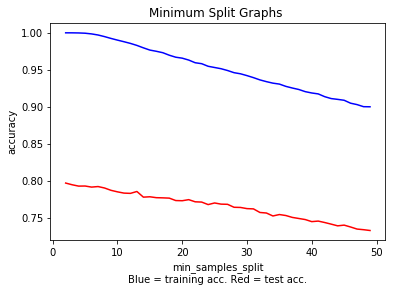

In [59]:
train_score = []
test_score = []

for min_samples_split in currRange:
    model = DecisionTreeClassifier(min_samples_split=min_samples_split)
    model.fit(X_train, y_train)
    
    test_score.append(model.score(X_test, y_test))
    train_score.append(model.score(X_train, y_train))
    
# plot max depth hyperparameter values vs training and test accuracy score
plt.plot(currRange, train_score, 'b', currRange, test_score, 'r')
plt.xlabel('min_samples_split\nBlue = training acc. Red = test acc.')
plt.ylabel('accuracy')
plt.title('Minimum Split Graphs ')
plt.show()

<p>If we compare the 'Minimum Spit Graph' to that of the 'Max Depth Graph' graph, it becomes clear that forcing additional splits both reduces over fitting and increases accuracy. However, there is still slight overfitting due to the Training Accuracy being more accurate than the Test accuracy.</p>

<h2>Task 2.2</h2>

In [60]:
# grid search CV
params = {'criterion': ['gini', 'entropy'],
          'max_depth': range(2, 7),
          'min_samples_leaf': range(20, 60, 10)}

cv = GridSearchCV(param_grid=params, estimator=DecisionTreeClassifier(random_state=rs), cv=10)
cv.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': range(2, 7), 'min_samples_leaf': range(20, 60, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

<h3>A: What is the classification accuracy on training and test datasets? </h3>   

In [61]:
print("Test Accuracy:", cv.score(X_test, y_test))
print("Train Accuracy:", cv.score(X_train, y_train))

Test Accuracy: 0.635868248970695
Train Accuracy: 0.6411157096650785


In [80]:
[n_nodes, leaf_count, main_variables] = getTreeInfo(cv.best_estimator_, feature_names) # Call the root function

<h3>B: What is the size of tree (i.e. number of nodes)? Is the size different from the maximal tree or the tree in the previous step? Why?</h3>

In [81]:
print("Number of Nodes:", n_nodes)

Number of Nodes: 121


<h3>C: How many leaves are in the tree that is selected based on the validation data set?</h3>  

In [82]:
print("Number of leaves:", leaf_count)

Number of leaves: 61


<h3>D: Which variable is used for the first split? What are the competing splits for this first split? </h3>  

In [83]:
print(main_variables)

Root feature is MMRCurrentAuctionPrice
Competing featues are VehBCostand VehOdo


<h3>E: What are the 5 important variables in building the tree?</h3>

In [84]:
feature_names = X.columns
analyse_feature_importance(cv.best_estimator_, feature_names, n_to_display=5)

MMRCurrentAuctionPrice : 0.3254368390494769
VehBCost : 0.11312300403115087
Body_CITY : 0.08948259372384197
AcquisitionAuctionprice : 0.0874002128428966
Auction_ADESA : 0.06196719392917188


<h3>F: Report if you see any evidence of model overfitting</h3> 

<p>As seen in Task 2.2 A - the test accuracy is very simmular to the train accuracy. This Indiates that there is no overfitting done, and that the model is indeed well balanced.</p>

<h3>G: What are the parameters used?</h3> 

In [85]:
analyse_feature_importance(cv.best_estimator_, feature_names, n_to_display=len(feature_names))

MMRCurrentAuctionPrice : 0.3254368390494769
VehBCost : 0.11312300403115087
Body_CITY : 0.08948259372384197
AcquisitionAuctionprice : 0.0874002128428966
Auction_ADESA : 0.06196719392917188
WheelType_COVERS : 0.054307486419571206
AcquisitionRetailPrice : 0.049541628184904166
VehOdo : 0.046420863532470664
MMRCurrentRetailRatio : 0.022231772380608868
TopThreeAmericanName_FORD : 0.01970079086521476
Size_MEDIUM : 0.01953723953130222
WarrantyCost : 0.01872626931318039
Auction_MANHEIM : 0.017444302346095463
Color_BLACK : 0.009491862496944985
VehYear_2002.0 : 0.00843380075465487
Make_CHEVROLET : 0.008146001555732802
Body_SUV : 0.0077776558792375635
Size_LARGE : 0.007563132021032389
VehYear_2007.0 : 0.006104006361781064
Color_GOLD : 0.005986323340600946
VehYear_2004.0 : 0.00540009804841695
VehYear_2006.0 : 0.005070416463215126
MMRCurrentRetailPrice : 0.004279824062851856
VehYear_2005.0 : 0.004254129599661995
TopThreeAmericanName_CHRYSLER : 0.0021725532659834968
Make_KIA : 0.0
Make_LINCOLN : 0.0


<h2>Task 2.3</h2>

There are three main differences to concider between the model in 2.1 and 2.2.

<b>Performance</b><br>
Due to the Node size in 2.1 (4000 < nodes), the model performance is much lower than that of 2.2 (100 > nodes). Meaning when running the, 2.2 finds a solution much faster than 2.1

<b>Accuracy</b><br>
Due to the size of the tree in 2.1, one would assume that the accuracy is much higher, however, this is only true for the TRAIN data. Due to the size of the model, overfitting occurs and reduces the accuracy of the model on the TEST data.

The model in 2.2 is much smaller and one would except lower accuracy, but due to the model being well generalized it actually outperforms the overfitted model in 2.1.

<b>Build Time</b><br>
Due to model 2.2 using a CV Grid Search to find optimal features, 2.2 takes longer to build that 2.1, even though 2.1 ends up being larger.

<h2>Task 2.4</h2>

In [86]:
print("TBC")

TBC


<h2>Task 3.1</h2>

<p>Yes there were values that needed to be Imputed. These Columns where:</p>
<div style='background: #f4f4f4; border: 1px solid #ddd;border-left: 3px solid #f36d33; color: #665; page-break-inside: avoid;    font-family: monospace;font-size: 15px; line-height: 1.6; margin-bottom: 1.6em;
    max-width: 100%;
    overflow: auto;
    padding: 1em 1.5em;
    display: block;
    word-wrap: break-word;'>
MMRAcquisitionAuctionAveragePrice <br>
MMRAcquisitionAuctionCleanPrice<br>
MMRAcquisitionRetailAveragePrice<br>
MMRAcquisitonRetailCleanPrice<br>
MMRCurrentAuctionAveragePrice<br>
MMRCurrentAuctionCleanPrice<br>
MMRCurrentRetailAveragePrice<br>
MMRCurrentRetailCleanPrice<br>
<br>
VehOdo<br>
VehBCost<br>
WarrantyCost<br>
</div>


<h2>Task 3.2</h2>
<p>
There were three main transformations done.<br><br>

<b>Averaging high correlating values</b><br>
After doing a correlation analysis it became clear that there is a very high correlation between the Average and the Clean price. Instead of dropping these values it was decided that the Average of the Average and Clean price will be transformed into a new varaibles. The resulting variable where
</p>
<p>Yes there were values that needed to be Imputed. These Columns where:</p>
<div style='background: #f4f4f4; border: 1px solid #ddd;border-left: 3px solid #f36d33; color: #665; page-break-inside: avoid;    font-family: monospace;font-size: 15px; line-height: 1.6; margin-bottom: 1.6em;
    max-width: 100%;
    overflow: auto;
    padding: 1em 1.5em;
    display: block;
    word-wrap: break-word;'>
MMRAcquisitionAuctionPrice<br>
MMRAcquisitonRetailPrice<br>
MMRCurrentAuctionPrice<br>
MMRCurrentRetailPrice<br>

<br>
VehOdo<br>
VehBCost<br>
WarrantyCost<br>
</div>
<b>Removing Outliers</b><br>
<p>After creating histograms and box plots it was noted that there is severe skew. The first step taken to remove the skew was to remove outliers for all varaibles.</p>

<b>Sqaure Root Transformations</b><br>
After the initial removal of outliers, more box plots and histograms were created. From this it was noted that the "Auction" variables still had some skew. To fix this these were transformed using the Sqaur Root of the varaible on the Price variables.
<p>Yes there were values that needed to be Imputed. These Columns where:</p>
<div style='background: #f4f4f4; border: 1px solid #ddd;border-left: 3px solid #f36d33; color: #665; page-break-inside: avoid;    font-family: monospace;font-size: 15px; line-height: 1.6; margin-bottom: 1.6em;
    max-width: 100%;
    overflow: auto;
    padding: 1em 1.5em;
    display: block;
    word-wrap: break-word;'>
MMRAcquisitionAuctionPrice<br>
MMRAcquisitonRetailPrice<br>
MMRCurrentAuctionPrice<br>
MMRCurrentRetailPrice<br>
</div>

<b>Log Transformations</b><br>
<p>some of the varaibles were found to be better suited to a Log transformation. These variables were:</p>
<div style='background: #f4f4f4; border: 1px solid #ddd;border-left: 3px solid #f36d33; color: #665; page-break-inside: avoid;    font-family: monospace;font-size: 15px; line-height: 1.6; margin-bottom: 1.6em;
    max-width: 100%;
    overflow: auto;
    padding: 1em 1.5em;
    display: block;
    word-wrap: break-word;'>
VehOdo<br>
WarrantyCost<br>
</div>
<b>Normilising Values</b><br>
All the variables were then normalized for consistancy.






<h2>Task 3.3</h2>


In [ ]:
# initialise a standard scaler object
scaler = StandardScaler()

for i in range(5):
    col = X_train[:,i]

X_train_regression = scaler.fit_transform(X_train, y_train)

for i in range(5):
    col = X_train[:,i]

X_test_regression = scaler.transform(X_test)

model = LogisticRegression(random_state=rs)

# fit it to training data
model.fit(X_train, y_train)

# grid search CV
params = {'C': [pow(10, x) for x in range(-6, 4)]}

# use all cores to tune logistic regression with C parameter
cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train, y_train)
model2 = cv.best_estimator_